In [1]:
import numpy as np

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [3]:
from factorgp import FactorGP
from inference import run_gibbs

In [4]:
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [6]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=10))

In [7]:
x = np.linspace(1, 100, 100)
curves = gp.sample_y(x.reshape((100, 1)), 100)
loading = np.random.normal(0, 1, [2, 15])

In [15]:
def generate_data(curves, loading, n, t):
    """
    Generate data with n repeated observations and t time points.
    """
    skip = 100 / t
    sampled_curves = curves[::skip, :]
    latent = []
    for i in range(n):
        factor = np.zeros((t, 2))
        factor[:, 0] = sampled_curves[:, i]
        factor[:, 1] = sampled_curves[:, i + 50]
        latent.append(factor)
    latent = np.concatenate(latent)
    Y_true = np.matmul(latent, loading)
    Y = Y_true + np.random.normal(0, 1, [int(n * t), 15])
    return Y_true, Y

In [9]:
def fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5):
    """
    Fit model and calculate posterior predictions.
    """
    dims = [n, t, 15, 2]
    model = FactorGP(dims, mu_var=[0, 1.0], gamma=[0.1 * t, 1])
    results = run_gibbs(Y, model, mcmc_size, 10, mcmc_step, verbose=False)
    F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results
    Y_sample = np.zeros((mcmc_size, int(n * t), 15))
    for i in range(mcmc_size):
        Y_sample[i, :, :] = np.matmul(F_sample[i, :, :], loading_sample[i, :, :])
    return Y_sample

In [16]:
def evaluate_fit(Y_sample, Y_true):
    """
    Evaluate model mean squared error and variance.
    """
    size = Y_sample.shape[0]
    Y_hat = np.median(Y_sample, axis=0)
    Y_error = np.mean((Y_hat - Y_true) ** 2)
    Y_variance = np.mean(np.std(Y_sample.reshape(size, (n * t * 15)), axis=0) ** 2)
    return Y_error, Y_variance

In [11]:
n = 1
t = 25
Y_true, Y = generate_data(curves, loading, n, t)
print(Y.shape)

(25, 15)


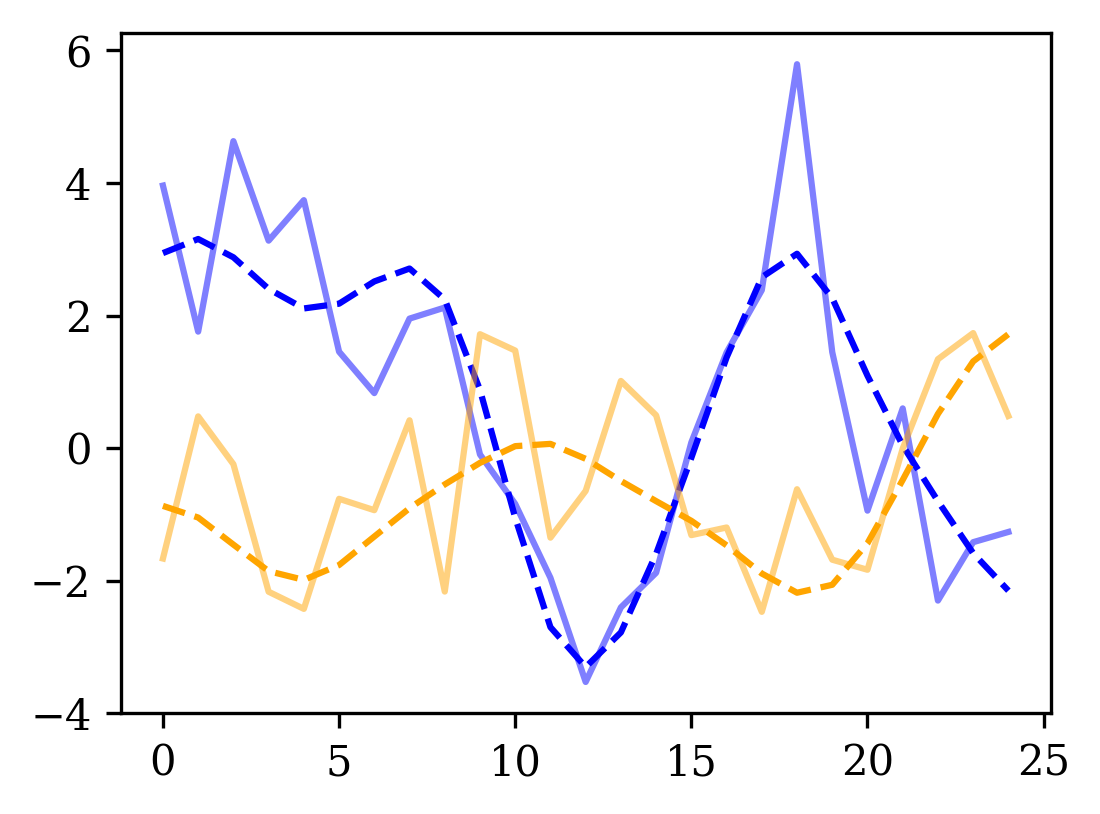

In [12]:
fig = plt.figure(figsize=(4, 3), dpi=300)
plt.plot(Y_true[:t, 0], '--', color='blue')
plt.plot(Y[:t, 0], alpha=0.5, color='blue')
plt.plot(Y_true[:t, 1], '--', color='orange')
plt.plot(Y[:t, 1], alpha=0.5, color='orange')
plt.show()

In [13]:
Y_sample = fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5)
Y_error, Y_variance = evaluate_fit(Y_sample, Y_true)

  0%|          | 0/100 [00:00<?, ?it/s]metropolis.py:69: RuntimeWarning: overflow encountered in exp
  if accept_new(np.exp(p_new - p)):
100%|██████████| 100/100 [00:16<00:00,  6.57it/s]


In [14]:
print(Y_error)
print(Y_variance)

0.13960675990559376
0.1609635642958785


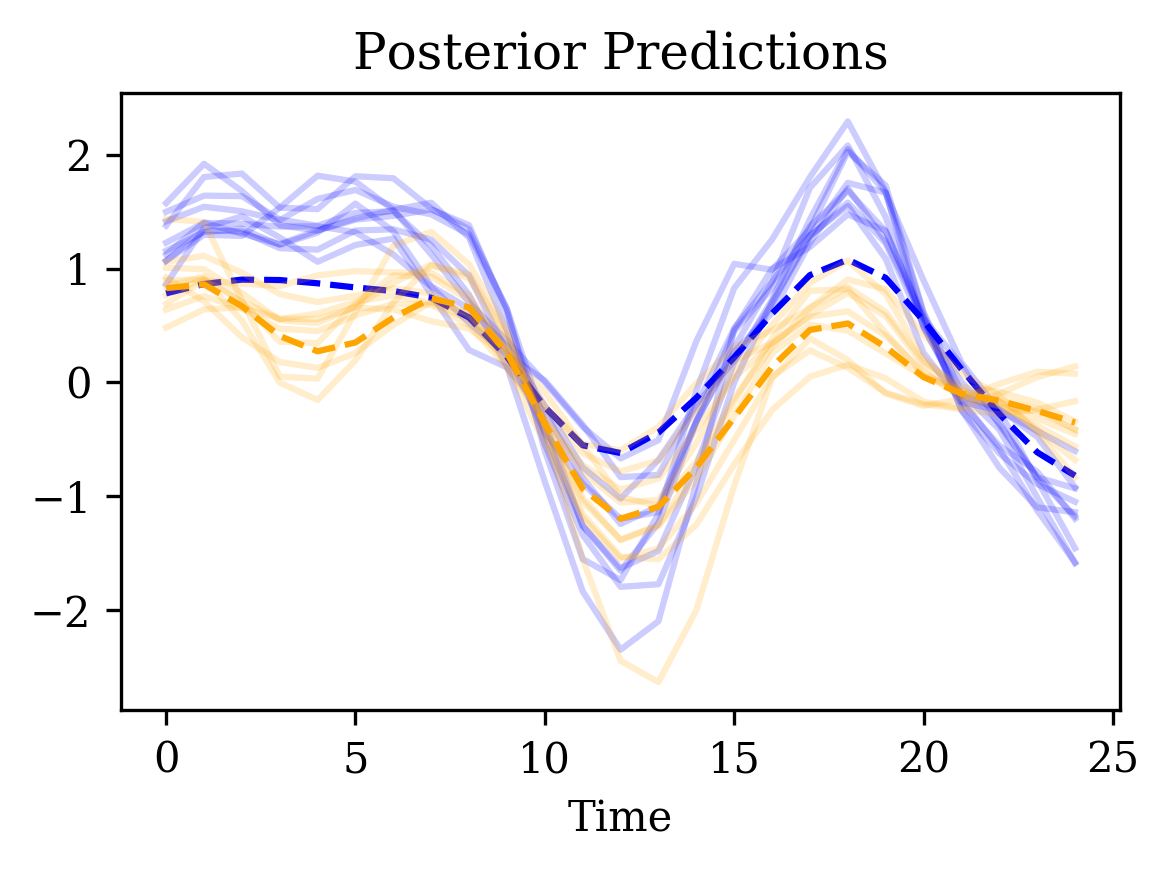

In [66]:
fig = plt.figure(figsize=(4, 3), dpi=300)
for i in range(10):
    plt.plot(Y_sample[i * 5 + 50, :t, 0], alpha=0.2, color='blue')
plt.plot(Y_true[:t, 0], '--', alpha=1.0, color='blue')
for i in range(10):
    plt.plot(Y_sample[i * 5 + 50, :t, 1], alpha=0.2, color='orange')
plt.plot(Y_true[:t, 1], '--', alpha=1.0, color='orange')
plt.title('Posterior Predictions')
plt.xlabel('Time')
fig.tight_layout()
fig.savefig('contraction_1.png')
plt.show()

In [16]:
n = 1
for t in [25, 50, 100]:
    Y_true, Y = generate_data(curves, loading, n, t)
    Y_sample = fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5)
    Y_error, Y_variance = evaluate_fit(Y_sample, Y_true)
    print(Y_error)
    print(Y_variance)

  0%|          | 0/100 [00:00<?, ?it/s]

0.12212116197376273
0.20225191693555022


  0%|          | 0/100 [00:00<?, ?it/s]

0.06911396684046196
0.075883836857115


100%|██████████| 100/100 [04:45<00:00,  2.48s/it]

0.03728533192844219
0.052186913937234417


In [24]:
n = 10
for t in [25, 50, 100]:
    Y_true, Y = generate_data(curves, loading, n, t)
    Y_sample = fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5)
    Y_error, Y_variance = evaluate_fit(Y_sample, Y_true)
    print(Y_error)
    print(Y_variance)

  0%|          | 0/100 [00:00<?, ?it/s]

0.07845237198036445
0.08743764759648912


  0%|          | 0/100 [00:00<?, ?it/s]

0.04123399008632206
0.058366563186976084


100%|██████████| 100/100 [03:46<00:00,  2.23s/it]

0.01682118503301928
0.0258205389148233


In [17]:
n = 20
for t in [25, 50, 100]:
    Y_true, Y = generate_data(curves, loading, n, t)
    Y_sample = fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5)
    Y_error, Y_variance = evaluate_fit(Y_sample, Y_true)
    print(Y_error)
    print(Y_variance)

  0%|          | 0/100 [00:00<?, ?it/s]

0.07089421275106873
0.07713501493405545


  0%|          | 0/100 [00:00<?, ?it/s]

0.032729753525072194
0.03989999687949191


100%|██████████| 100/100 [04:04<00:00,  2.19s/it]

0.016729153423282274
0.019072476183985124


In [18]:
n = 50
for t in [25, 50, 100]:
    Y_true, Y = generate_data(curves, loading, n, t)
    Y_sample = fit_model(Y, n, t, mcmc_size=100, mcmc_step=0.5)
    Y_error, Y_variance = evaluate_fit(Y_sample, Y_true)
    print(Y_error)
    print(Y_variance)

  0%|          | 0/100 [00:00<?, ?it/s]

0.05868958200390178
0.07388581675675582


  0%|          | 0/100 [00:00<?, ?it/s]

0.032369455148989645
0.0370969661608592


100%|██████████| 100/100 [04:25<00:00,  2.50s/it]


0.0167283253115991
0.026588491937847042
